<h2>Abstract</h2>
<p>
TSP（巡回セールスマン問題）は、ある都市から出発し、全ての都市を訪れて元の都市に戻ることを考えた時に、総移動距離が一番最短となるルートを求める最適化問題です。<br>
TSPは組み合わせ最適化問題の中でも代表的な問題の1つで、NP困難と呼ばれる問題のクラスに属します。<br>
<br>
一般的にはこういった問題は最適化手法で解きます。<br>
一方で、近年ではニューラルネットワークや深層学習が発展したことにより、深層強化学習を使ったアプローチ手法も提案されています。<br>
<br>
このノートブックでは、TSPを深層強化学習で解いてみた場合、どのような実装になるのか試しており、うまく解けましたので、それについて記します。<br>
<br>
モデルの学習ではGPUを使いたいので、全てのコードをkaggleノートブックに書いて実施します。<br>
<br>
===================<br>
<br>
Traveling salesman problem (TSP) is an optimization problem to solve the route with the shortest total travel distance when starting from a city, visiting all cities, and returning to the start city.<br>
TSP is one of the combinatorial optimization problems and belongs to a class NP-hard.<br>
<br>
We can solve the problem by a general optimization method.<br>
On the other hand, with the recent development of deep learning, approach methods using deep reinforcement learning have also been proposed. <br>
<br>
In this notebook, it will describe that tried to solve TSP using deep reinforcement learning.<br>
<br>
We want to use the GPU for training the model, so all code will be written in a kaggle notebook. (this notebook)<br>
<br>
</p>

<h2>(1) Library</h2>

In [1]:
!pip install pulp > /dev/null 2>&1

In [2]:
import os
import math
import random
import itertools
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

use_cuda = torch.cuda.is_available()
torch.__version__, use_cuda

('1.4.0', True)

<h2>(2) Constants</h2>

In [3]:
### Common

SEED = 777
N_CUSTOMER = 14
N_POINT = N_CUSTOMER + 1

### Deep reinforcement learning

EMBEDDING_SIZE = 128
HIDDEN_SIZE = 128
N_GLIMPSES = 1
TANH_EXPLORATION = 10
USE_TANH = True
BETA = 0.99
MAX_GRAD_NORM = 2.
N_EPOCH = 1000

<h2>(3) Functions</h2>

<h3>(3.1) function</h3>

In [4]:
### Common

def fix_seed(seed: int):
    """Fix random seeds.
    
    Args:
        seed (int): Given random seed.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
    
fix_seed(SEED)


def prepare_tsp(n_point: int) -> pd.DataFrame:
    """Generate TSP state.
    
    Args:
        n_point (int): The number of city points it must visit.
        
    Returns:
        pd.DataFrame: Dataframe having coordinates of points of cities.
    """
    df = pd.DataFrame({
        "x": np.random.randint(0, 100, n_point),
        "y": np.random.randint(0, 100, n_point),
    })
    df.iloc[0]["x"] = 0
    df.iloc[0]["y"] = 0
    
    return df


def get_distances(df: pd.DataFrame) -> np.ndarray:
    """Calculate distance matrix from given coordinates of points of cities.
    
    Args:
        df (pd.DataFrame): Dataframe having coordinates of points of cities.
        
    Returns:
        np.ndarray: Distance matrix.
    """
    distances = pd.DataFrame(
        distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), 
        index=df.index, 
        columns=df.index,
    )
    
    return distances.values
    
    
def plot_distance_matrix(distances: np.ndarray):
    """Plot given distance matrix as a heatmap.
    
    Args:
        distances (np.ndarray): Given distance matrix.
    """
    fig, ax = plt.subplots(figsize=(13, 11))
    sns.heatmap(
        distances, 
        ax=ax, 
        cmap="Blues", 
        annot=True, 
        fmt=".0f", 
        cbar=True, 
        cbar_kws={"shrink": .3}, 
        linewidths=.1,
    )
    plt.title("distance matrix")
    plt.show()
    
    
def plot_tsp_state(df: pd.DataFrame, routes=[]):
    """Plot TSP state. state (points of cities).
    
    Args:
        df (pd.DataFrame): Dataframe having coordinates of points of cities.
        routes (list): List of points of traveling route. Default is []. If len(routes) = 0, it don't plot.
    """
    plt.figure(figsize=(5, 5))

    # Draw the problem state
    for i, row in df.iterrows():
        if i == 0:
            plt.scatter(row["x"], row["y"], c="r")
            plt.text(row["x"] + 1, row["y"] + 1, "depot")
        else:
            plt.scatter(row["x"], row["y"], c="black")
            plt.text(row["x"] + 1, row["y"] + 1, f"{i}")

    plt.xlim([-10, 110])
    plt.ylim([-10, 110])
    
    if len(routes) > 0:
        arrowprops = dict(arrowstyle="->", connectionstyle="arc3", edgecolor="blue")
        for i, j in routes:
            plt.annotate(
                "", 
                xy=[df.iloc[j]["x"], df.iloc[j]["y"]], 
                xytext=[df.iloc[i]["x"], df.iloc[i]["y"]], 
                arrowprops=arrowprops,
            )
        
    plt.show()
    
    
### Deep reinforcement learning
    
def reward(sample_solution, use_cuda=use_cuda):
    """Calculate reward. (In this case, reward is the total distance of sample_solution)
    
    Args:
        sample_solution (list[torch.Tensor]): Predicted route.
        use_cuda (bool): Use cuda or not.
        
    Returns:
        torch.Tensor: Reward.
    """
    batch_size = sample_solution[0].size(0)
    n = len(sample_solution) # sample_solution is seq_len of [batch_size]
    tour_len = (
        Variable(torch.zeros([batch_size])).cuda() if use_cuda else Variable(torch.zeros([batch_size]))
    )
    for i in range(n - 1):
        tour_len += torch.norm(sample_solution[i] - sample_solution[i + 1], dim=1)
    tour_len += torch.norm(sample_solution[n - 1] - sample_solution[0], dim=1)

    return tour_len


def plot_reward_loss(trainer):
    """Plot reward curve and loss curve during training.
    
    Args:
        trainer (Trainer): Trainer class.
    """
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(trainer.train_tour, color="skyblue")
    ax1.set_ylabel("reward")

    ax2.plot(trainer.train_loss, color="orange")
    ax2.set_ylabel("loss")

    ax1.set_xlabel("epoch")

    fig.tight_layout()
    plt.title("reward and loss")
    plt.show()


<h3>(3.2) Class</h3>

In [5]:
### MIP

class TSPSolver:
    def __init__(self, n_point: int, distances: np.ndarray):
        """Make TSPSolver instance.
    
        Args:
            n_point (int): The number of city points it must visit.
            distances (np.ndarray): Distance matrix.
        """
        self.n_point = n_point
        self.distances = distances
        self.problem = None
        self.x = None
        self.u = None
        self.status = None
        
    def set_problem(self):
        """Set the problem.
        """
        # Set the problem
        self.problem = pulp.LpProblem("tsp_mip", pulp.LpMinimize)

        # Set valiables
        self.x = pulp.LpVariable.dicts(
            "x", 
            ((i, j) for i in range(self.n_point) for j in range(self.n_point)), 
            lowBound=0, 
            upBound=1,
            cat="Binary",
        )
        # We need to keep track of the order in the tour to eliminate the possibility of subtours
        self.u = pulp.LpVariable.dicts(
            "u", 
            (i for i in range(self.n_point)), 
            lowBound=1, 
            upBound=self.n_point, 
            cat="Integer",
        )

        # Set objective function
        self.problem += pulp.lpSum(
            self.distances[i][j] * self.x[i, j] for i in range(self.n_point) for j in range(self.n_point)
        )

        # Set constrains
        for i in range(self.n_point):
            self.problem += self.x[i, i] == 0

        for i in range(self.n_point):
            self.problem += pulp.lpSum(self.x[i, j] for j in range(self.n_point)) == 1
            self.problem += pulp.lpSum(self.x[j, i] for j in range(self.n_point)) == 1

        # Eliminate subtour
        for i in range(self.n_point):
            for j in range(self.n_point):
                if i != j and (i != 0 and j != 0):
                    self.problem += self.u[i] - self.u[j] <= self.n_point * (1 - self.x[i, j]) - 1
                    
    def solve(self):
        """Solve the problem.
        """
        # Solve the problem
        self.status = self.problem.solve()
        
    def check_status(self):
        """Get the status (status, 'Optimal' or 'Infeasible', Solved objective function value).
        
        Returns:
            int, str, float: Status of the problem, 'Optimal' or 'Infeasible', Solved objective function value.
        """
        # output status, value of objective function
        return self.status, pulp.LpStatus[self.status], pulp.value(self.problem.objective)
    
    
### Deep reinforcement learning

class Attention(nn.Module):
    def __init__(self, hidden_size, use_tanh=False, C=10, use_cuda=use_cuda):
        """Make Attension instance.
    
        Args:
            hidden_size (int): Size of hidden layer.
            use_tanh (bool): Use tanh or not.
            C (int): tanh exploration.
            use_cuda (bool): Use cuda or not.
        """
        super(Attention, self).__init__()
        self.use_tanh = use_tanh
        self.C = C

        # Bahdanau algo
        self.W_query = nn.Linear(hidden_size, hidden_size)
        self.W_ref   = nn.Conv1d(hidden_size, hidden_size, 1, 1)

        V = torch.cuda.FloatTensor(hidden_size) if use_cuda else torch.FloatTensor(hidden_size)
        self.V = nn.Parameter(V)
        self.V.data.uniform_(
            -(1. / math.sqrt(hidden_size)) , 1. / math.sqrt(hidden_size)
        )
        
    def forward(self, query, ref):
        """Forward function.
    
        Args:
            query (torch.Tensor): Query.
            ref (torch.Tensor): Ref.
            
        Returns:
            torch.Tensor, torch.Tensor: Ref, logits score.
        """
        # query = [batch_size, hidden_size]
        # ref   = [batch_size, seq_len, hidden_size]
        batch_size = ref.size(0)
        seq_len    = ref.size(1)
        
        # Bahdanau algo
        ref = ref.permute(0, 2, 1)
        query = self.W_query(query).unsqueeze(2)                           # [batch_size x hidden_size x           1]
        ref   = self.W_ref(ref)                                            # [batch_size x hidden_size x     seq_len] 
        expanded_query = query.repeat(1, 1, seq_len)                       # [batch_size x hidden_size x     seq_len]
        V = self.V.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1)      # [batch_size x           1 x hidden_size]
        logits = torch.bmm(V, torch.tanh(expanded_query + ref)).squeeze(1)
        
        if self.use_tanh:
            logits = self.C * torch.tanh(logits)
            
        return ref, logits
    
    
class GraphEmbedding(nn.Module):
    def __init__(self, input_size, embedding_size, use_cuda=use_cuda):
        """Make GraphEmbedding instance.
    
        Args:
            input_size (int): Size of input.
            embedding_size (int): Size of embedding.
            use_cuda (bool): Use cuda or not.
        """
        super(GraphEmbedding, self).__init__()
        self.embedding_size = embedding_size
        self.use_cuda = use_cuda
        
        self.embedding = nn.Parameter(torch.FloatTensor(input_size, embedding_size)) 
        self.embedding.data.uniform_(
            -(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size)
        )
        
    def forward(self, inputs):
        """Forward function.
    
        Args:
            inputs (torch.Tensor): Input tensor.
            
        Returns:
            torch.Tensor: Embedded tensor.
        """
        # inputs = [batch_size, input_size, seq_len]
        batch_size = inputs.size(0)
        seq_len    = inputs.size(2)
        embedding = self.embedding.repeat(batch_size, 1, 1)  
        embedded = []
        inputs = inputs.unsqueeze(1)
        for i in range(seq_len):
            embedded.append(torch.bmm(inputs[:, :, :, i].float(), embedding))
        embedded = torch.cat(embedded, 1)
        
        return embedded
    
    
class PointerNet(nn.Module):
    def __init__(self, 
                 embedding_size, 
                 hidden_size, 
                 seq_len, 
                 n_glimpses, 
                 tanh_exploration, 
                 use_tanh, 
                 use_cuda=use_cuda):
        """Make PointerNet instance.
    
        Args:
            embedding_size (int): Size of embedding.
            hidden_size (int): Size of hidden layer.
            seq_len (int): Length of sequence. (In this case, the number of cities)
            n_glimpses (int): The number of encoder vectors to reference in attention/glimpse.
            tanh_exploration (int): tanh exploration.
            use_tanh (bool): Use tanh or not.
            use_cuda (bool): Use cuda or not.
        """
        super(PointerNet, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size    = hidden_size
        self.n_glimpses     = n_glimpses
        self.seq_len        = seq_len
        self.use_cuda       = use_cuda
        
        self.embedding = GraphEmbedding(2, embedding_size, use_cuda=use_cuda)
        self.encoder   = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.decoder   = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.pointer   = Attention(
            hidden_size, 
            use_tanh=use_tanh,
            C=tanh_exploration, 
            use_cuda=use_cuda,
        )
        self.glimpse   = Attention(
            hidden_size, 
            use_tanh=False, 
            use_cuda=use_cuda,
        )
        
        self.decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
        self.decoder_start_input.data.uniform_(
            -(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size)
        )
        
    def apply_mask_to_logits(self, logits, mask, idxs):
        """Apply mask to logits.
    
        Args:
            logits (torch.Tensor): Logits.
            mask (torch.Tensor): Mask.
            idxs (torch.Tensor or None): Idxs.

        Returns:
            torch.Tensor, torch.Tensor: Logits, cloned mask.
        """
        batch_size = logits.size(0)
        clone_mask = mask.clone()

        if idxs is not None:
            clone_mask[[i for i in range(batch_size)], idxs.data] = 1
            logits[clone_mask] = -np.inf
            
        return logits, clone_mask
            
    def forward(self, inputs):
        """Forward function.
    
        Args:
            inputs (torch.Tensor): Input tensor.
            
        Returns:
            list[torch.Tensor], list[torch.Tensor]: Probabilities, idxs.
        """
        # inputs = [batch_size, 1, seq_len]
        batch_size = inputs.size(0)
        seq_len    = inputs.size(2)
        
        embedded = self.embedding(inputs)
        encoder_outputs, (hidden, context) = self.encoder(embedded)
        
        prev_probs    = []
        prev_idxs     = []
        mask          = (
            torch.zeros(batch_size, seq_len).byte().cuda() if self.use_cuda else torch.zeros(batch_size, seq_len).byte()
        )
        idxs          = None
        decoder_input = self.decoder_start_input.unsqueeze(0).repeat(batch_size, 1)
        
        for i in range(seq_len):
            
            _, (hidden, context) = self.decoder(decoder_input.unsqueeze(1), (hidden, context))
            
            query = hidden.squeeze(0)
            for i in range(self.n_glimpses):
                ref, logits = self.glimpse(query, encoder_outputs)
                logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
                query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2) 
                
            _, logits = self.pointer(query, encoder_outputs)
            logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
            probs = F.softmax(logits)
            
            idxs = probs.multinomial(num_samples=1).squeeze(1)
            for old_idxs in prev_idxs:
                if old_idxs.eq(idxs).data.any():
                    idxs = probs.multinomial(num_samples=1).squeeze(1)
                    break
            decoder_input = embedded[[i for i in range(batch_size)], idxs.data, :] 
            
            prev_probs.append(probs)
            prev_idxs.append(idxs)
        
        return prev_probs, prev_idxs
    
    
class NeuralCombinatorialOptimization(nn.Module):
    def __init__(self, 
                 embedding_size, 
                 hidden_size, 
                 seq_len, 
                 n_glimpses, 
                 tanh_exploration, 
                 use_tanh, 
                 reward, 
                 use_cuda=use_cuda):
        """Make NeuralCombinatorialOptimization instance.
    
        Args:
            embedding_size (int): Size of embedding.
            hidden_size (int): Size of hidden layer.
            seq_len (int): Length of sequence. (In this case, the number of cities)
            n_glimpses (int): The number of encoder vectors to reference in attention/glimpse.
            tanh_exploration (int): tanh exploration.
            use_tanh (bool): Use tanh or not.
            reward (reward function): Defined reward function.
            use_cuda (bool): Use cuda or not.     
        """
        super(NeuralCombinatorialOptimization, self).__init__()
        self.reward   = reward
        self.use_cuda = use_cuda
        
        self.actor = PointerNet(
            embedding_size, 
            hidden_size, 
            seq_len, 
            n_glimpses, 
            tanh_exploration, 
            use_tanh, 
            use_cuda,
        )

    def forward(self, inputs):
        """Forward function.
    
        Args:
            inputs (torch.Tensor): Input tensor.
            
        Returns:
            torch.Tensor, list[torch.Tensor], list[torch.Tensor], list[torch.Tensor]: Reward, probabilities, actions, idxs of actions.
        """
        # inputs = [batch_size, input_size, seq_len]
        batch_size = inputs.size(0)
        input_size = inputs.size(1)
        seq_len    = inputs.size(2)
        
        probs, action_idxs = self.actor(inputs)
       
        actions = []
        inputs = inputs.transpose(1, 2)
        for action_id in action_idxs:
            actions.append(inputs[[x for x in range(batch_size)], action_id.data, :])
            
        action_probs = []    
        for prob, action_id in zip(probs, action_idxs):
            action_probs.append(prob[[x for x in range(batch_size)], action_id.data])

        R = self.reward(actions, self.use_cuda)
        
        return R, action_probs, actions, action_idxs
    
    
class Trainer:
    def __init__(self, 
                 model, 
                 train_data, 
                 max_grad_norm=2.,
                 beta=0.99, 
                 use_cuda=use_cuda):
        """Make Trainer instance.
    
        Args:
            model (NeuralCombinatorialOptimization): Model which will be trained.
            train_data (torch.Tensor): Train data.
            max_grad_norm (float): max grad norm.
            beta (float): beta.
            use_cuda (bool): Use cuda or not.
        """
        self.model         = model
        self.use_cuda      = use_cuda
        
        self.train_data    = train_data.unsqueeze(0)
        self.train_data    = (
            Variable(self.train_data).cuda() if use_cuda else Variable(self.train_data)
        )

        self.actor_optim   = optim.Adam(model.actor.parameters(), lr=1e-4)
        self.max_grad_norm = max_grad_norm
        self.beta = beta
        
        self.train_loss = []
        self.train_tour = []
        self.epochs     = 0
        
    def train(self, n_epochs: int):
        """Train the model.
    
        Args:
            n_epochs (int): The number of epoch.
        """
        critic_exp_mvg_avg = torch.zeros(1).cuda() if self.use_cuda else torch.zeros(1)
        
        self.model.train() # Set train mode
        iterator = tqdm(range(n_epochs))
        
        for epoch in iterator:
            iterator.set_description(f"epoch {epoch + 1}/{n_epochs}")
            
            R, probs, actions, actions_idxs = self.model(self.train_data)

            critic_exp_mvg_avg = (critic_exp_mvg_avg * self.beta) + ((1. - self.beta) * R.mean())
            advantage = R - critic_exp_mvg_avg

            logprobs = 0
            for prob in probs: 
                logprob = torch.log(prob)
                logprobs += logprob
            logprobs[logprobs < -1000] = 0.  

            reinforce = advantage * logprobs
            actor_loss = reinforce.mean()

            self.actor_optim.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(
                self.model.actor.parameters(), 
                float(self.max_grad_norm), 
                norm_type=2,
            )

            self.actor_optim.step()
            critic_exp_mvg_avg = critic_exp_mvg_avg.detach()

            l = float(actor_loss.data)
            r = float(R.mean().data)
            self.train_loss.append(l)
            self.train_tour.append(r)
            self.epochs += 1
            
            iterator.set_postfix(loss="{}".format(l), reward="{}".format(r))
                    
        self.model.eval() # Set not train mode
            
    def predict(self):
        """Predict on the train data.

        Returns:
            torch.Tensor, list[torch.Tensor], list[torch.Tensor], list[torch.Tensor]: Reward, probabilities, actions, idxs of actions.
        """
        R, probs, actions, actions_idxs = self.model(self.train_data)
        
        return R, probs, actions, actions_idxs

<h2>(3) Prepare TSP</h2>

In [6]:
# Define TSP: Traveling Salesman Problem
df = prepare_tsp(N_POINT)

# Get the distance matrix
distances = get_distances(df)

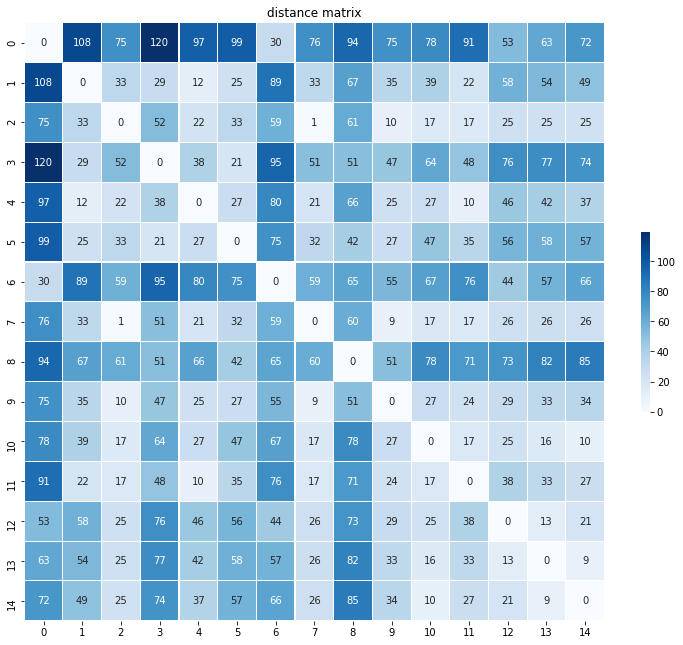

In [7]:
# Plot the distance matrix
plot_distance_matrix(distances)

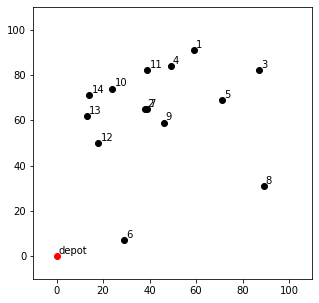

In [8]:
# Plot TSP state
plot_tsp_state(df)

<h2>(4) Solve using MIP(Mixed Integer Problem)</h2>
<p>
まずは一般的な方法として、混合整数計画法（MIP: Mixed Integer Problem）をPuLPで実装して解いてみます。<br>
<br>
===================<br>
<br>
First, as a general method, solve using mixed integer programming (MIP: Mixed Integer Programming) by PuLP.<br>
<br>
</p>

In [9]:
# Define the problem and solve
tsp_solver = TSPSolver(n_point=N_POINT, distances=distances)
tsp_solver.set_problem()
tsp_solver.solve()
tsp_solver.check_status()

(1, 'Optimal', 345.4749473240595)

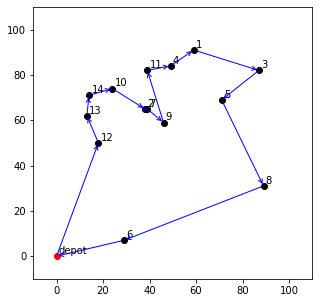

In [10]:
# Plot TSP state and optimized route
routes = [(i, j) for i in range(N_POINT) for j in range(N_POINT) if pulp.value(tsp_solver.x[i, j]) == 1]
plot_tsp_state(df, routes)

<h2>(5) Solve using Deep Reinforcement Learning</h2>
<p>
深層学習モデルのアーキテクチャはPointer Networkと呼ばれるモデルを試しました。<br>
<br>
<b>- Pointer Networks: <a href="https://arxiv.org/abs/1506.03134">https://arxiv.org/abs/1506.03134</a></b><br>
<br>
Pointer Networkは2017年にGoogleが出した論文で提案されたモデルであり、その少し前に登場したばかりの<b><a href="https://arxiv.org/abs/1409.3215">Seq2Seq</a></b>から派生したモデルです。<br>
予測・出力のイメージはSeq2Seqと同様に、入力シーケンスと出力シーケンスがあり、TSPにおいては、入力は単に都市のポイント列を入力して都市位置情報を与え、予測においては巡回する都市ポイントの列を出力します。<br>
<br>
学習の方法なのですが、Pointer Networksの論文の中でもTSPへの応用は言及されていますが、その中では最適化手法による解を教師データとして学習させています。<br>
一方で、下記の論文にて、深層強化学習の枠組みで考えることで、探索的に最適巡回路を求める学習方法が提案されています。<br>
<br>
<b>- Neural Combinatorial Optimization with Reinforcement Learning: <a href="https://arxiv.org/abs/1611.09940">https://arxiv.org/abs/1611.09940</a></b><br>
<br>
報酬は負の総移動距離で、ポリシーで提案した移動の順番の総移動距離が短くなればなるほど報酬が上がっていくように学習します。<br>
<br>
今回はこれらをPyTorchで実装して試してみました。<br>
<br>
===================<br>
<br>
Next, as the deep learning model architecture, tried a model called Pointer Network.<br>
<br>
<b>- Pointer Networks: <a href="https://arxiv.org/abs/1506.03134">https://arxiv.org/abs/1506.03134</a></b><br>
<br>
Pointer Network is a model proposed by Google in 2017 applying <b><a href="https://arxiv.org/abs/1409.3215">Seq2Seq</a></b>.<br>
The image of an input and an output is similar to Seq2Seq, with an input sequence and an output sequence, in TSP, an input is a simple sequence of city points (location information), and an output is a sequence of city points of traveling route.<br>
<br>
About a learning method, the application to TSP in mentioned in the paper of Pointer Network, and the solution from the optimization method is used as train data for learning model.<br>
On the other hand, the following paper proposes a learning method to find the optimal route exploratorily with the framework of deep reinforcement learning.<br>
<br>
<b>- Neural Combinatorial Optimization with Reinforcement Learning: <a href="https://arxiv.org/abs/1611.09940">https://arxiv.org/abs/1611.09940</a></b><br>
<br>
The reward is the negative total distance of traveling, which is learned so that the shorter the total distance of traveling route that is proposed by the policy to get higher reward.<br>
In this notebook, implemented and tried the method using PyTorch.<br>
<br>
</p>

In [11]:
# Define the model
model = NeuralCombinatorialOptimization(
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    seq_len=N_POINT, 
    n_glimpses=N_GLIMPSES, 
    tanh_exploration=TANH_EXPLORATION,
    use_tanh=USE_TANH,
    reward=reward,
    use_cuda=use_cuda,
)

if use_cuda:
    model = model.cuda()

In [12]:
# Set trainer
train_data = torch.tensor(df.values.transpose(), dtype=torch.float32)
trainer = Trainer(model, train_data)

In [13]:
# Train
trainer.train(n_epochs=N_EPOCH)

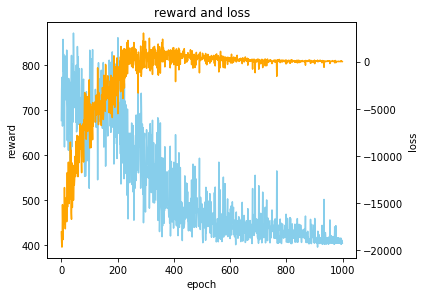

In [14]:
# Plot rewards and losses
plot_reward_loss(trainer)

<h2>Note:</h2>
<p>
学習結果は上記の通りで、報酬が先ほどMIPで解いた最短距離に近くなっていっているのが分かります。<br>
<br>
===================<br>
<br>
The train result are above, you can see that the reward are getting closer to the shortest distance from solution by MIP.<br>
<br>
</p>

In [15]:
# Predict using trained model
R, probs, actions, actions_idxs = trainer.predict()

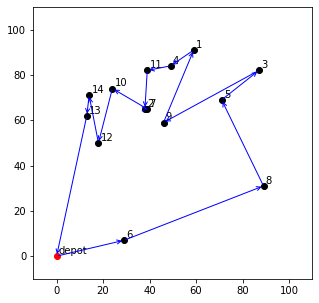

In [16]:
# Plot TSP state and predicted optimized route
routes = [int(tensor) for tensor in actions_idxs]
routes = [(routes[i-1], routes[i]) for i in range(len(routes))]
plot_tsp_state(df, routes)

<h2>Insights:</h2>
<p>
学習させたモデルで最短経路を予測させてみた結果をグラフでプロットしてみると上記の通りで、ほぼ最適解のルートを予測できました。<br>
<br>
うまく解法できたものの、個人的には、いまいち有効とは言い切れないような感じだと思いました。<br>
やはり問題自体の組み合わせ数が闇雲な探索にはハードすぎると思ったことと、近年発展してきている深層学習や強化学習の効果的な方法を、まだあまりこのような分野に適用し切れていないように思いました。<br>
この実装をしていた時にも思いましたが、入力情報をわざわざ系列データで入力しなくても良いのでは？<br>
一応、詳しく調べ切れていませんが、TransformerベースでVRPにアプローチする論文もあるみたいです。<br>
<br>
また、ある程度これよりも大きい規模でかつ条件が頻繁に変わる（都市座標が毎回変わるなど）状態だと、有効な場合もあるのかなと思いました。<br>
最適化手法では毎回解くのに実行時間がかかってしまいますが、このような手法ならランダムに都市情報を変えたトレーニングデータでモデルを長時間学習させたものを持っていれば、毎回推論だけで済むのかなと思います。<br>
<br>
あと、今回の実装で一番頑張ったのは、Matplotlibで矢印を描くところだったかもしれない。<br>
<br>
===================<br>
<br>
The result of predicting the shortest route with the trained model are plotted in the above graph, and you can see that the model can predict almost the optimal solution.<br>
<br>
Although it could solve the problem almost successfully, but I felt that it was not quite valid method.<br>
I thought that the number of combinations of the problem was too hard to search randomly, and effective methods of deep learning and reinforcement learning, which have been developed in recent years, have not been applied yet in the field.<br>
When I was implementing this, I thought why does input information of points of cities as a sequence?<br>
There somewhat are papers that propose a method based on Transformer to solve VRP, although I have not been able to research well.<br>
<br>
I wondered if it might be effective on larger scale problem and conditions change frequently. (e.g. city coordinates change each time)<br>
In the case, optimization methods take a lot of run time to solve each time, but deep reinforcement learning method, if you have a trained model on training data with randomly changed city coordinates, I think you can just inference time.<br>
<br>
By the way, the hardest part of this notebook may have been drawing arrows using matplotlib, haha.<br>
<br>
</p>

In [17]:
!pip freeze > requirements.txt
!python --version > py_ver.txt
!cat /proc/driver/nvidia/version > nvidia_ver.txt